In [25]:
import json
import json
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def fix_json_format(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            parsed_data = json.loads(content)
        print(f"JSON in '{file_path}' is valid.")
        return parsed_data
    ##json ???

    except json.JSONDecodeError as e:
        print(f"JSONDecodeError in '{file_path}': {e}")
        
        error_location = e.pos
        print(f"Error at position: {error_location}")
        
        fixed_content = fix_json(content)
        
        try:
            parsed_data = json.loads(fixed_content)
            with open(file_path, 'w') as file:
                file.write(fixed_content)
            print(f"Fixed and saved JSON in '{file_path}'.")
            return parsed_data
        except json.JSONDecodeError as e:
            print(f"Unable to fix JSON in '{file_path}': {e}")
            return None

def fix_json(content):
    fixed_content = content.replace("], [", "], [")  
    return fixed_content


##main
file_path = 'annotations.json'

data = fix_json_format(file_path)

JSON in 'annotations.json' is valid.


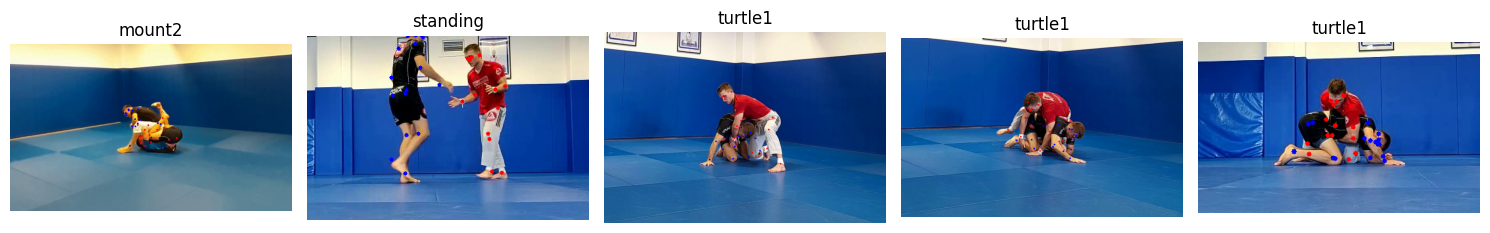

In [3]:
with open('annotations.json') as f:
    annotations = json.load(f)

valid_annotations = [a for a in annotations if "pose1" in a and "pose2" in a]

image_dir = 'images'

def visualize_pose(image_path, pose1, pose2, title):
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pose, color in zip([pose1, pose2], ['red', 'blue']):
        if pose:
            for point in pose:
                x, y, c = point
                if c > 0.1:  
                    cv2.circle(
                        image, (int(x), int(y)), 3,
                        (255 if color == 'red' else 0, 0, 255 if color == 'blue' else 0),
                        -1
                    )

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

num_samples = min(5, len(valid_annotations))

if num_samples == 0:
    print("No valid annotations with both pose1 and pose2.")
else:
    samples = random.sample(valid_annotations, num_samples)

    plt.figure(figsize=(15, 10))
    for i, ann in enumerate(samples):
        img_name = ann.get("image", "unknown") + ".jpg"
        image_path = os.path.join(image_dir, img_name)
        plt.subplot(1, num_samples, i + 1)
        visualize_pose(
            image_path,
            ann.get("pose1"),
            ann.get("pose2"),
            ann.get("position", "Unknown")
        )

    plt.tight_layout()
    plt.show()

# Data Preparation for Pose Classification

We are working with a dataset of human poses, where each data point includes:

- **pose1**: Keypoints for one person.
- **pose2**: Keypoints for a second person.
- **A label**: Describing their spatial position (e.g., "facing", "standing side by side", etc.).

---

##  Previous Approach (Flat Vector)

In the earlier model, `pose1` and `pose2` were simply concatenated into a single vector:

- **Input shape**: `[batch_size, 68]` where `68 = 34 (pose1) + 34 (pose2)`.

### Limitations:
- Ignored the sequential relationship between the two poses.
- Treated both poses as one flat set of numbers, losing the notion that one is `pose1` and the other is `pose2`.

---

##  Improved Approach (Sequence of Poses)

We now structure the input as a sequence of two pose vectors:

- **Input shape**: `[batch_size, 2, 34]`.

### Each sequence contains:
1. **Time step 0**: `pose1` (34 keypoint coordinates).
2. **Time step 1**: `pose2` (34 keypoint coordinates).

This allows our Vision Transformer to learn from the order and relationship between the two poses.

---

##  Why This Is Better

- **Enables temporal or structural modeling**: `pose1` then `pose2` (like time steps).
- **Prepares data for sequence models**: (e.g., LSTMs or Transformers).
- **Helps the model learn interaction patterns**: Between the two individuals.


In [7]:
train_anns, temp_anns = train_test_split(valid_annotations, test_size=0.3, random_state=42)
val_anns, test_anns = train_test_split(temp_anns, test_size=0.5, random_state=42)

print(f"Train: {len(train_anns)}, Val: {len(val_anns)}, Test: {len(test_anns)}")

# Create a mapping from position label to class ID
positions = list(set(a["position"] for a in valid_annotations))
position_to_id = {pos: i for i, pos in enumerate(positions)}

# Encode a single pose into a flat list of (x, y) coordinates
def encode_pose(pose):
    return [coord for keypoint in pose for coord in keypoint[:2]]  # Use only x and y

# Prepare data in [B, 2, 34] format
def prepare_data(annotations):
    X = []
    y = []
    for ann in annotations:
        pose1 = encode_pose(ann["pose1"])  # [34]
        pose2 = encode_pose(ann["pose2"])  # [34]
        
        sequence = [pose1, pose2]          # [[34], [34]] → [2, 34]
        X.append(sequence)
        y.append(position_to_id[ann["position"]])
    
    return np.array(X, dtype=np.float32), np.array(y)

# Prepare all splits
X_train, y_train = prepare_data(train_anns)
X_val, y_val     = prepare_data(val_anns)
X_test, y_test   = prepare_data(test_anns)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Wrap into PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

Train: 53440, Val: 11451, Test: 11452
X_train shape: (53440, 2, 34), y_train shape: (53440,)
X_val shape: (11451, 2, 34), y_val shape: (11451,)
X_test shape: (11452, 2, 34), y_test shape: (11452,)


In [15]:
poses = set(positions)
print("Classes(poses):", poses)
print("Number of classes:", len(positions))

Classes(poses): {'mount1', 'open_guard1', 'back1', 'turtle2', 'open_guard2', 'side_control2', 'takedown2', 'half_guard2', 'closed_guard1', 'side_control1', '5050_guard', 'standing', 'turtle1', 'takedown1', 'half_guard1', 'closed_guard2', 'mount2', 'back2'}
Number of classes: 18


# Model Architecture for Pose Classification

#### We use a Transformer-based classifier to predict the spatial relationship between two people using their pose keypoints. Each input is a sequence of two poses: `pose1` and `pose2`.

---

### 🔄 Improvements Over Previous Model

| Feature                | Previous Model | Transformer Model |
|------------------------|----------------|-------------------|
| **Input Format**       | Flat [68]      | Sequence [2, 34] |
| **Architecture**       | Dense Feedforward | Transformer Encoder |
| **Handles Pose Order** | ❌ No          | ✅ Yes            |
| **Learns Pose Interactions** | ❌ No      | ✅ Yes (via self-attention) |
| **Suited for Sequences** | ❌ No        | ✅ Yes            |

---
This change dramatically improves the model’s ability to learn relational patterns and generalize better to real scenarios.

In [16]:
class PoseTransformer(nn.Module):
    def __init__(self, input_dim=34, embed_dim=64, num_heads=4, num_classes=18, dropout=0.1):
        super(PoseTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: [batch_size, 2, 34]
        x = self.embedding(x)  # -> [batch_size, 2, embed_dim]
        x = self.transformer_encoder(x)  # -> [batch_size, 2, embed_dim]
        out = self.classifier(x)  # -> [batch_size, num_classes]
        return out


In [18]:
class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PoseDataset(X_train, y_train)
val_dataset = PoseDataset(X_val, y_val)
test_dataset = PoseDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [21]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total


In [22]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/10 - Loss: 1102.1523 - Val Acc: 0.9243
Epoch 2/10 - Loss: 494.0432 - Val Acc: 0.9551
Epoch 3/10 - Loss: 462.0780 - Val Acc: 0.9426
Epoch 4/10 - Loss: 407.6789 - Val Acc: 0.9604
Epoch 5/10 - Loss: 280.0256 - Val Acc: 0.9703
Epoch 6/10 - Loss: 300.6790 - Val Acc: 0.9645
Epoch 7/10 - Loss: 291.9423 - Val Acc: 0.9666
Epoch 8/10 - Loss: 232.4637 - Val Acc: 0.9715
Epoch 9/10 - Loss: 202.2660 - Val Acc: 0.9802
Epoch 10/10 - Loss: 197.8055 - Val Acc: 0.9758


In [23]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Accuracy
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.9770


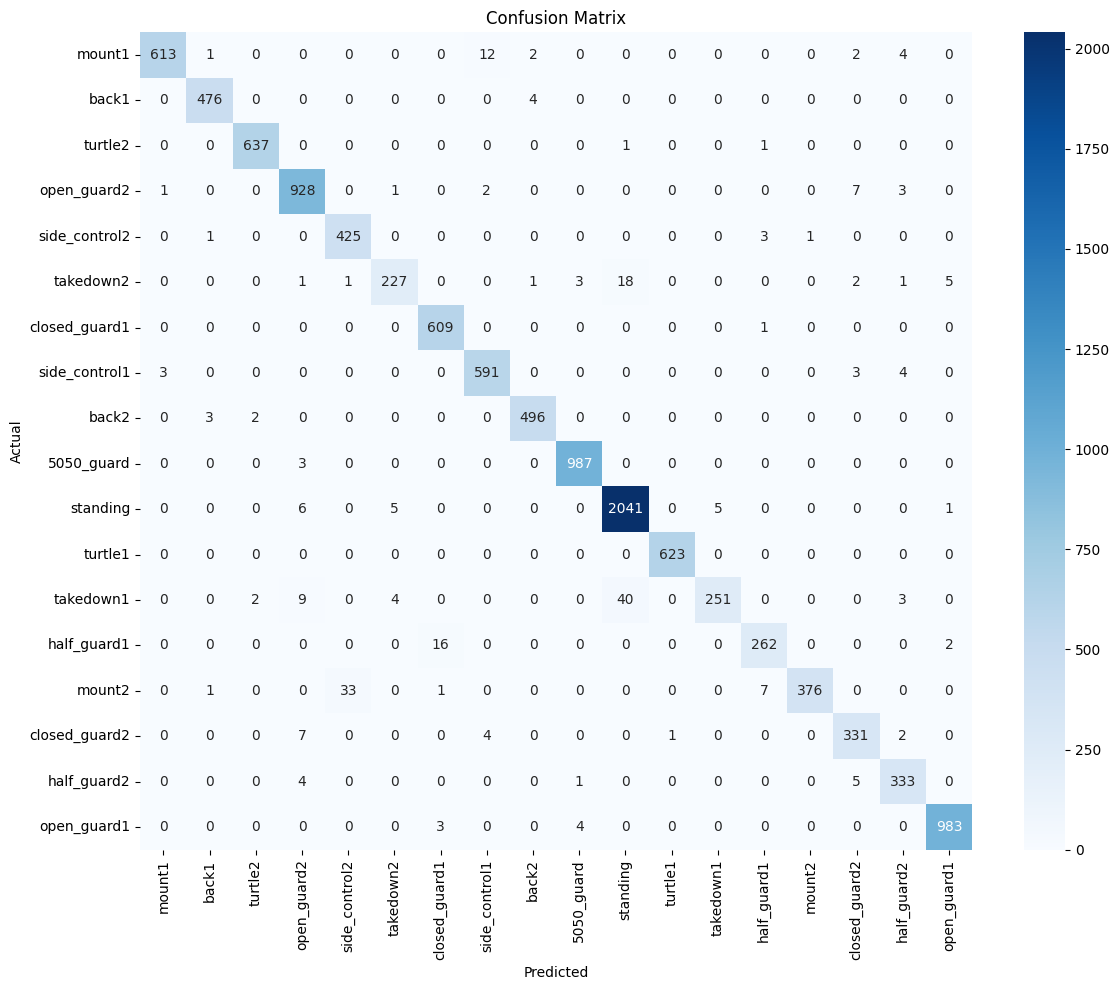


📋 Classification Report:
               precision    recall  f1-score   support

       mount1       0.99      0.97      0.98       634
        back1       0.99      0.99      0.99       480
      turtle2       0.99      1.00      1.00       639
  open_guard2       0.97      0.99      0.98       942
side_control2       0.93      0.99      0.96       430
    takedown2       0.96      0.88      0.92       259
closed_guard1       0.97      1.00      0.98       610
side_control1       0.97      0.98      0.98       601
        back2       0.99      0.99      0.99       501
   5050_guard       0.99      1.00      0.99       990
     standing       0.97      0.99      0.98      2058
      turtle1       1.00      1.00      1.00       623
    takedown1       0.98      0.81      0.89       309
  half_guard1       0.96      0.94      0.95       280
       mount2       1.00      0.90      0.95       418
closed_guard2       0.95      0.96      0.95       345
  half_guard2       0.95      0.97    

In [26]:
# List of class names
class_names = ['mount1', 'back1', 'turtle2', 'open_guard2', 'side_control2', 'takedown2', 
               'closed_guard1', 'side_control1', 'back2', '5050_guard', 'standing', 'turtle1', 
               'takedown1', 'half_guard1', 'mount2', 'closed_guard2', 'half_guard2', 'open_guard1']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


## ✅ Upgrades Implemented

### Feature Description
- 🔢 **Variable sequence length**: Accepts `seq_len > 2`
- 📍 **Positional encoding**: Adds temporal awareness
- 📈 **Joint confidence support**: Optional, with `input_dim = 51`
- 🧠 **Normalized input**: Scale-invariant joint coordinates
- 🔍 **Self-attention visualization-ready**: Access to attention weights
- 🧪 **More modular design**: Clean architecture